## How to create a FeatureSet for path separation

### 1. Create a FeatureSet in the order of the `pullf` Files

When working with **pathwise estimates**, the **order of the trajectories is critical**.
If you already initialized a `ForceSet`, `WorkSet`, `WorkEstimator`, or `ForceEstimator`, we strongly recommend using the `names_` instance together with the wildcard option. This ensures that the file order used for the feature set matches the order used during initialization.

The following cell shows the filename order of a `workset` initialized with:

```bash
pullf_files = '../../tests/testdata/*pullf.xvg'
filenames = dcTMD.io.load_pullf(pullf_files)
```

This uses a shell-style wildcard (`*pullf.xvg`) to **glob** all matching files.

Below, we compare the resulting order with the order stored in the `pullf_filenames.dat` file.



In [1]:
import numpy as np
from dcTMD import storing

pullf_files = '../../tests/testdata/pullf_filenames.dat'
pullf_filenames = np.loadtxt(pullf_files, dtype=str)

workestimator = storing.load('my_workestimator')

print(workestimator.names_)
print(pullf_filenames)


['t_middle_32_pullf.xvg' 't_middle_28_pullf.xvg' 't_middle_09_pullf.xvg'
 't_middle_25_pullf.xvg' 't_middle_03_pullf.xvg' 't_middle_04_pullf.xvg'
 't_middle_17_pullf.xvg' 't_middle_01_pullf.xvg' 't_middle_30_pullf.xvg'
 't_middle_21_pullf.xvg' 't_middle_05_pullf.xvg' 't_middle_29_pullf.xvg'
 't_middle_31_pullf.xvg' 't_middle_19_pullf.xvg' 't_middle_16_pullf.xvg'
 't_middle_26_pullf.xvg' 't_middle_24_pullf.xvg' 't_middle_34_pullf.xvg']
['testdata/t_middle_01_pullf.xvg' 'testdata/t_middle_03_pullf.xvg'
 'testdata/t_middle_04_pullf.xvg' 'testdata/t_middle_05_pullf.xvg'
 'testdata/t_middle_09_pullf.xvg' 'testdata/t_middle_16_pullf.xvg'
 'testdata/t_middle_17_pullf.xvg' 'testdata/t_middle_19_pullf.xvg'
 'testdata/t_middle_21_pullf.xvg' 'testdata/t_middle_24_pullf.xvg'
 'testdata/t_middle_25_pullf.xvg' 'testdata/t_middle_26_pullf.xvg'
 'testdata/t_middle_28_pullf.xvg' 'testdata/t_middle_29_pullf.xvg'
 'testdata/t_middle_30_pullf.xvg' 'testdata/t_middle_31_pullf.xvg'
 'testdata/t_middle_32_pu

As you can see from the printed output, the order of the filenames differs between the `workestimator` and the `pullf_filenames.dat` file.
For **pathwise predictions**, this order is crucial: each feature vector must correspond to the correct trajectory in the estimator. If the order in the feature set does not match the order stored in the estimator, the predictions will be misaligned and therefore incorrect.

To ensure valid pathwise estimates, always verify that:

* the **feature set**,
* the **work/force estimator**, and
* the **trajectory filenames**

all share the **same order**.

If they do not match, you must reorder the feature set or reload the estimator with consistent input.

#### Illustrating the Concept with Dummy Data

We now demonstrate it using simple **1D** and **2D** dummy data.
In practice, such data could represent any trajectory-dependent quantity—for example, the **distance between two residues** over time.

By using the trajectory names stored in the `workestimator`, we ensure that the features are loaded in a **consistent and matching order**.



In [2]:

from dcTMD.featureset import FeatureSet

wildcard = '../../tests/testdata/feature_1D_{}.txt'
pullf_filenames = workestimator.names_
featureset = FeatureSet(
    filenameprefix=pullf_filenames,
    wildcard=wildcard,
    verbose=False,
)
featureset.fill_array()

feature_array = featureset.array

feature_array.shape

Loading files: 100%|██████████| 18/18 [00:00<00:00, 5244.70it/s]


(18, 100)

Creating a festureset with 1D data results in a 2D NumPy array with shape:

```
(num_trajectories, num_timepoints)
```

Note that the number of timepoints often differs from the number of steps in the corresponding `pullf` files. This is because the **xtc trajectory files are typically saved at a lower temporal resolution** than the `pullf` files, leading to fewer sampled timepoints in the feature data.

#### Visualizing the feature data: Line Plots and a 2D Histogram

To better understand the structure of the feature data, we first visualize the trajectories as simple line plots.
Each line corresponds to one trajectory and shows how the feature value evolves over time.

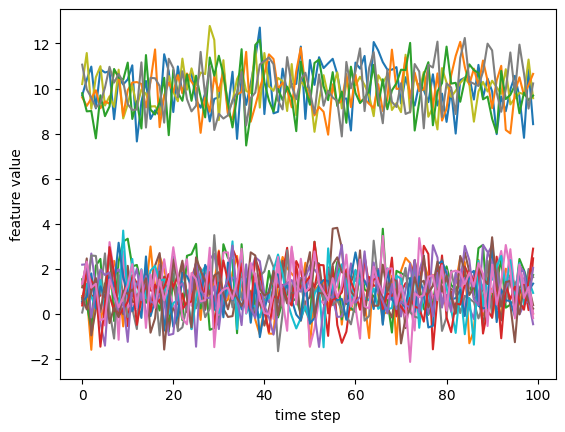

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
n_tray, timesteps = feature_array.shape
for n in range(n_tray):
    ax.plot(feature_array[n, :])

ax.set(xlabel="time step", ylabel="feature value")
plt.show()


Next, we construct a **2D histogram** that shows how frequently certain feature values occur at each time step across all trajectories.
Zero entries are treated as `np.nan`.

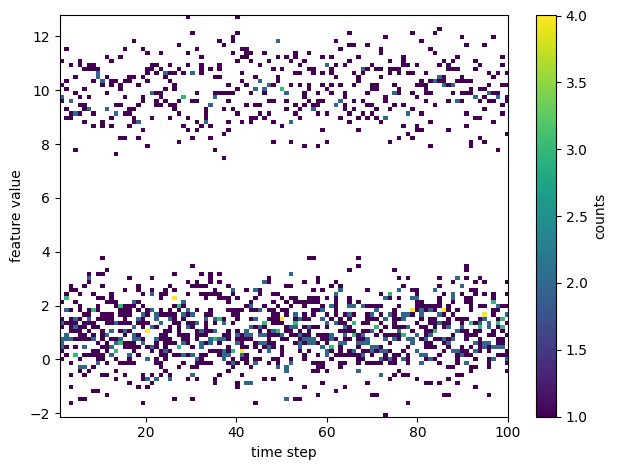

In [4]:
feature_array_nan = np.where(feature_array == 0, np.nan, feature_array)
histo = np.histogram2d(
    np.tile(np.linspace(1, 100, feature_array.shape[1]), feature_array.shape[0]),
    feature_array_nan.flatten(),
    bins=(100, 100),
    range=[[1, 100], [np.min(feature_array), np.max(feature_array)]],
)[0].T
histo_nan = np.where(histo == 0, np.nan, histo)

fig, ax = plt.subplots()
im = ax.imshow(
    histo_nan,
    aspect='auto',
    origin='lower',
    interpolation='nearest',
    extent=(1, 100, np.min(feature_array), np.max(feature_array)),
)
fig.colorbar(im, ax=ax, label='counts')
ax.set(xlabel="time step", ylabel="feature value")
plt.tight_layout()
plt.show()



### Multidimensional Data

The same procedure applies when working with **multidimensional features**.
In the next example, the data set does not represent just the distance between *two* residues, but the distances between **ten different residue pairs**.

This results in a feature array with an additional dimension, where each time point contains a vector of measurements instead of a single value. The workflow remains identical—only the data structure becomes richer, allowing you to analyze patterns across multiple residue pairs simultaneously.

#### Visualizing Multidimensional Feature Data

When the feature data is **multidimensional**, each trajectory contains multiple measurements at every time point—for example, the distances between **ten different residue pairs**.
This produces a 3D array with shape:

```
(n_traj, n_timesteps, n_features)
```

where `n_features = 10` in this example.

To explore this data, we can visualize:

1. All features for a single trajectory, or
2. A single feature across all trajectories, or
3. A histogram for each feature to capture its distribution over time.

Below, we show two useful visualizations:
**a line plot per feature**, and a **stacked 2D histogram grid**.


In [5]:
wildcard = '../../tests/testdata/feature_2D_{}.txt'
pullf_filenames = workestimator.names_
featureset = FeatureSet(
    filenameprefix=pullf_filenames,
    wildcard=wildcard,
    verbose=False,
)
featureset.fill_array()

feature_array = featureset.array

n_traj, n_timesteps, n_features = feature_array.shape

Loading files: 100%|██████████| 18/18 [00:00<00:00, 1682.69it/s]


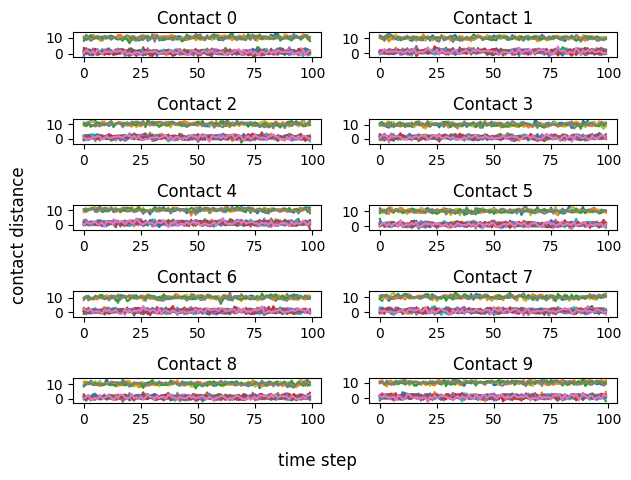

In [6]:
fig, axs = plt.subplots(ncols=2, nrows=5)
fig.supxlabel('time step')
fig.supylabel('contact distance')
ax = axs.flatten()
for feature_ndx in range(n_features):
    for n in range(n_traj):
        ax[feature_ndx].plot(feature_array[n, :, feature_ndx])
    ax[feature_ndx].set_title(f'Contact {feature_ndx}')

plt.tight_layout()
plt.show()



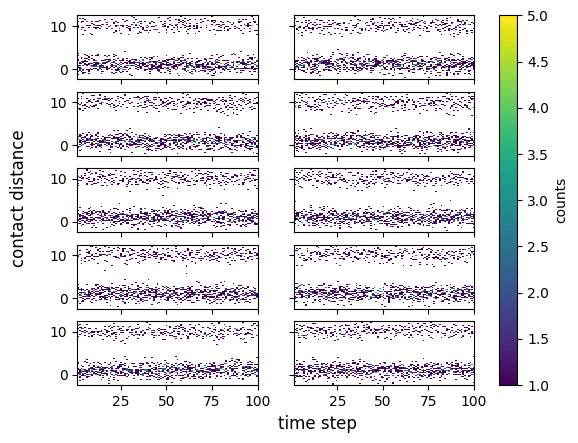

In [7]:
fig, axs = plt.subplots(ncols=2, nrows=5, sharex=True, sharey=True)
fig.supxlabel('time step')
fig.supylabel('contact distance')
ax = axs.flatten()
feature_array_nan = np.where(feature_array == 0, np.nan, feature_array)
n_contacts = feature_array.shape[-1]

for feature_ndx in range(n_contacts):
    contact_feature_array = feature_array[:, :, feature_ndx]
    histo = np.histogram2d(
        np.tile(np.linspace(1, 100, contact_feature_array.shape[1]), contact_feature_array.shape[0]),
        contact_feature_array.flatten(),
        bins=(100, 100),
        range=[
            [1, 100],
            [np.min(contact_feature_array), np.max(contact_feature_array)],
        ],
    )[0].T
    histo_nan = np.where(histo == 0, np.nan, histo)
    im = ax[feature_ndx].imshow(
        histo_nan,
        aspect='auto',
        origin='lower',
        interpolation='nearest',
        extent=(1, 100, np.min(contact_feature_array), np.max(contact_feature_array)),
    )
fig.colorbar(im,  ax=axs, label='counts')
#plt.tight_layout()
plt.show()

### Computing Euclidean Distances Between Trajectories

In the multidimensional case, each trajectory is described by $N$ feature values at every time point.
We can interpret each time point as a ND vector:

$$
\mathbf{x}(t) = (x_1(t), x_2(t), ..., x_N(t)
$$

To compare two trajectories, a simple and intuitive approach is to compute the **Euclidean distance** between their time-dependent feature vectors.

For two trajectories (A) and (B), the Euclidean distance at each time step is:

$$
d(t) = \lVert \mathbf{x}_A(t) - \mathbf{x}_B(t) \rVert_2
$$

The result is a 1D array describing how similar or different the two trajectories are over time.
We can then summarize the overall distance between the two trajectories by computing the average distance over all time steps:

$$
d_{AB} = \frac{1}{T} \sum_{t=1}^{T} d(t)
$$


In [8]:
import tqdm

def _euclidean_dist(X, Y):
    """as implemented in
    https://doi.org/10.1021/acs.jctc.4c00250
    """
    trj_length = X.shape[1]
    d = np.zeros(trj_length)
    for t in range(trj_length):
        d[t] = np.sqrt(np.sum((X[t] - Y[t])**2))
    return np.mean(d)

def SimMatrix(feature_array, simmeasure):
    """
    Compute the similarity matrix using a custom similarity measure.
    Parameters
    ----------
    feature_array : ndarray
        A 3D array of shape (n_trj, trj_length, n_contacts) containing the features of the trajectories.
    simmeasure : callable
        A function that computes the similarity between two trajectories. 
        It should take two arguments (X, Y) and return a scalar similarity value.
    Returns
    -------
    matrix_ : ndarray
        A 2D array of shape (n_trj, n_trj) representing the similarity matrix, 
        where each entry is the normalized similarity between two trajectories.
    Examples
    --------
    >>> import numpy as np
    >>> feature_array = np.random.rand(5, 100, 3)  # Example feature array
    >>> simmeasure = _euclidean_dist  # Example similarity measure
    >>> similarity_matrix = SimMatrix(feature_array, simmeasure)
    >>> print(similarity_matrix)
    """
    n_trj, trj_length, n_features = feature_array.shape
    total_iterations = int(
            .5 * n_trj * (n_trj + 1)
        )
    dist = np.zeros(shape=(n_trj, n_trj))
    with tqdm.tqdm(total=total_iterations) as pbar:
        for i in range(n_trj):
            for j in range(i+1):
                X = feature_array[i]
                Y = feature_array[j]
                d = simmeasure(X, Y)
                dist[i, j] = d
                dist[j, i] = d
                pbar.update(1)
    dist = dist
    max_dist = dist.max()
    if max_dist == 0:
        raise ValueError(
            'Maximum distance is zero, cannot normalize similarity matrix.')
    matrix_ = 1 - dist / max_dist
    return matrix_

#### Creating a Similarity Matrix

To quantitatively compare trajectories, we compute a **similarity matrix** based on a distance measure between pairs of trajectories.
Each entry $(i, j)$ represents how similar trajectory $i$ is to trajectory $j$, computed using a user-defined metric (here, the mean Euclidean distance between their feature vectors over time).

After computing all pairwise distances, we normalize them into a similarity score in the range $[0, 1]$, where:

* $1$ → trajectories are identical
* $0$ → trajectories are maximally different


In [9]:
similarity_matrix = SimMatrix(feature_array, _euclidean_dist)

100%|██████████| 171/171 [00:00<00:00, 9674.07it/s]


#### Plotting
The two following plots show that by design the dataset contains:

* **highly similar clusters** (similarity values close to $1$), and
* **strongly dissimilar clusters** (similarity values closer to $0$).

##### Similarity Matrix

Once the similarity matrix has been computed, we can visualize it as a **heatmap** and use it for clustering.

##### Similarity Distribution

By also plotting the **distribution of similarity values**, we gain a global view of how the trajectories relate to one another.

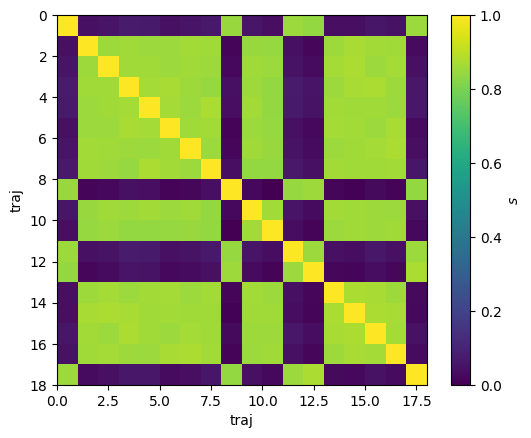

In [10]:
fig, ax = plt.subplots()
im = ax.pcolormesh(similarity_matrix)
ax.invert_yaxis()  # origin to the upper left
ax.set_aspect('equal')  # 1:1 ratio
ax.set_xlabel('traj')
ax.set_ylabel('traj')
ax.grid(False)
plt.colorbar(im, label=r'$s$')
plt.show()

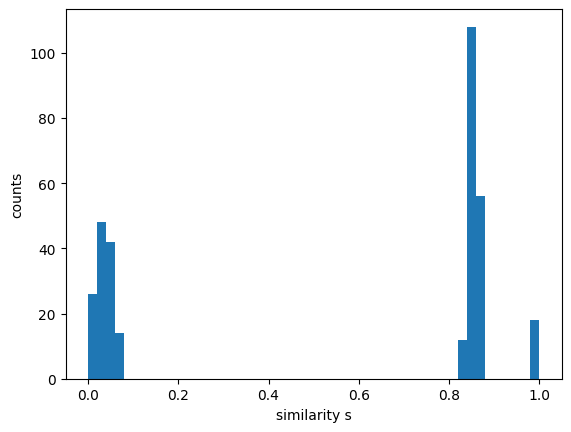

In [11]:
plt.hist(similarity_matrix.flatten(), bins=50)
plt.xlabel('similarity s')
plt.ylabel('counts')
plt.show()

### Clustering the Similarity Matrix Using MoSAIC (CPM + Leiden)

To reveal structural patterns within the similarity matrix, we use the **MoSAIC** Python package.
You can find it [here](https://github.com/moldyn/MoSAIC).

In this tutorial, we apply **CPM clustering** (Constant Potts Model), a community-detection method that identifies groups of trajectories based on their pairwise similarities. MoSAIC optimizes CPM using the **Leiden algorithm**.

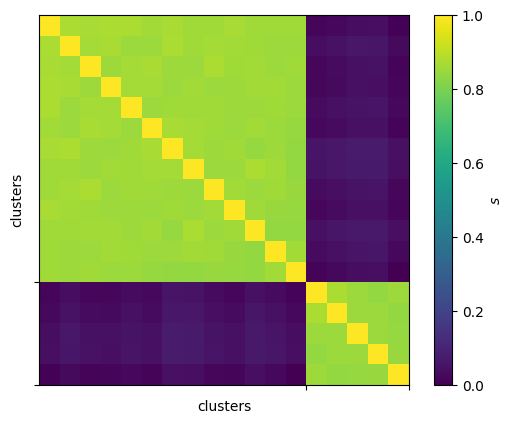

In [12]:
import mosaic

# Cluster the similarity matrix
clustering = mosaic.Clustering(
    mode='CPM',
    weighted=True,
    resolution_parameter=0.5,
)
clustering.fit(similarity_matrix)

fig, ax = plt.subplots()
im = ax.pcolormesh(clustering.matrix_)
ax.invert_yaxis()  # origin to the upper left
ax.set_aspect('equal')  # 1:1 ratio
ax.set_xticks(clustering.ticks_)
ax.set_yticks(clustering.ticks_)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('clusters')
ax.set_ylabel('clusters')
ax.grid(False)
plt.colorbar(im, label=r'$s$')
plt.show()


### Computing dcTMD Estimates for Each Cluster

Once the trajectories have been clustered (e.g. using MoSAIC with CPM + Leiden), we can compute **separate dcTMD estimates for each cluster**.
This allows us to compare trajectory groups—such as different unbinding pathways.

For each cluster, we:

1. Extract the trajectory indices belonging to that cluster.
2. Reduce the original `workset` to include only those trajectories.
3. Fit a new `WorkEstimator` using the reduced dataset.
4. Optionally smooth the friction profile for better interpretability.
5. Plot the dcTMD results (work, friction, free energy, etc.) for that cluster.

The following code performs exactly this procedure:

Each plot corresponds to one cluster and visualizes its **cluster-specific dcTMD profile**.

[14, 15, 16, 13, 2, 5, 3, 4, 6, 1, 7, 9, 10]


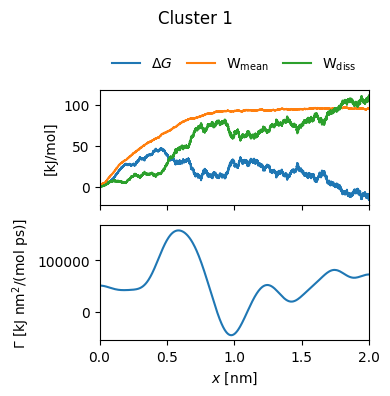

[12, 17, 11, 0, 8]


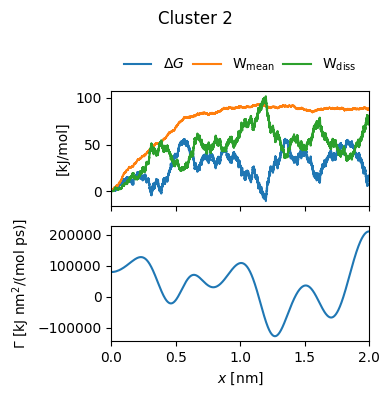

In [13]:
# plot dcTMD results
from dcTMD.utils import plotting
from dcTMD.dcTMD import WorkEstimator

# use work.ipynb to save 'my_workset' in cell 5, comment in
# "dcTMD.storing.save('my_workset', workset)"
workset = storing.load('my_workset')
temperature = 300
for i, cluster_list in enumerate(clustering.clusters_):
    print(cluster_list)
    # create WorkEstimator instance
    workestimator = WorkEstimator(temperature)
    # convert cluster list to numpy array
    cluster_list = np.asarray(cluster_list)
    current_workset = workset.reduce(cluster_list)
    workestimator.fit(current_workset)
    workestimator.smooth_friction(sigma=0.1)

    fig, axs = plotting.plot_dcTMD_results(workestimator)
    fig.suptitle(f'Cluster {i+1}')
    plt.tight_layout()
    plt.show()
